In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
np.random.seed(42)

# Classification using k-Nearest Neighbors

To start our journey in machine learning, we shall begin with the k-nearest neighbors algorithm (k-NN). It is a so-called non-parametric method used for classification and regression tasks. To illustrate data analysis, we shall start by generating synthetic data from a simple generative model, and see how good k-NN is when trying to classify these data.

Let us first generate these synthetic data. Our *generative model* will be one of the favortie models of statisticians: the Gaussian mixture model (GMM). To spice things up a bit, we shall generate the data point this way: for each class, we first sample 10 different centroids ${\vec m}_k$ from $\mathcal{N} ({\vec m}_k; {\vec 0}, I_2)$, then pick centroids at random and sample the actual data ${\vec x}_i$ from $\mathcal{N} ({\vec x}_i; {\vec m}_k, \frac{1}{5} I_2)$.

We start by sampling the centroids and plotting them. Since we do this for pedagogical purpose, we shall consider points in two dimensions.

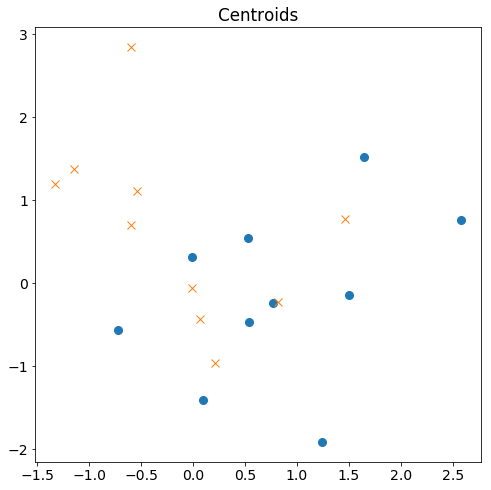

In [2]:
# Samples 10 centroids for each class from two different bivariate Normal distributions
centroids_per_class = 10

class0_centroids = [1, 0] + np.random.randn(centroids_per_class, 2)
class1_centroids = [0, 1] + np.random.randn(centroids_per_class, 2)

# Plot centroids
plt.plot(class0_centroids[:, 0], class0_centroids[:, 1], "o", markersize=8)
plt.plot(class1_centroids[:, 0], class1_centroids[:, 1], "x", markersize=8)
plt.title("Centroids")

Once we have the centroids we can sample the actual data: we will sample many points arround these centroids with a Gaussian distribution.

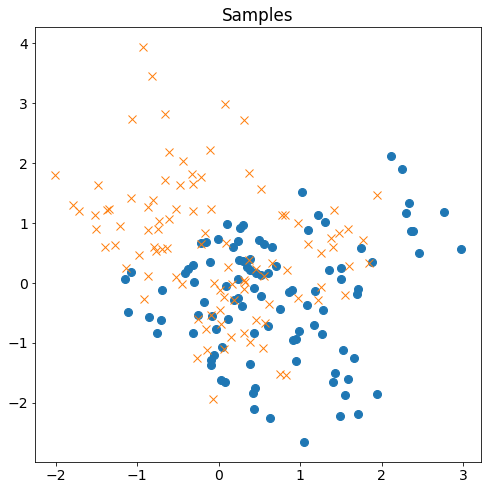

In [3]:
samples_per_class = 100

# Sample actual data sampling from Normal distributions positioned around the centroids
class0_labels = np.random.randint(10, size = samples_per_class)
class1_labels = np.random.randint(10, size = samples_per_class)

class0_samples = class0_centroids[class0_labels, :] + np.sqrt(1. / 5) * np.random.randn(samples_per_class, 2)
class1_samples = class1_centroids[class1_labels, :] + np.sqrt(1. / 5) * np.random.randn(samples_per_class, 2)

# Plot data
plt.plot(class0_samples[:, 0], class0_samples[:, 1], "o", markersize=8)
plt.plot(class1_samples[:, 0], class1_samples[:, 1], "x", markersize=8)
plt.title("Samples")

This is the problem we want to solve: we are given these points and we want to find a decision boundary that ensures generalization, i.e. that we are gonna be able to correctly classify new samples once they are given to us (for these new points, we do not know the label).

Let us group the data in a nice way. For binary classification problems like this one, the way data is usually arranged is in

- a feature matrix $X$ of size $N \times P$, where $N$ is the number of samples and $P$ is the number of features (in our case $N = 200$ and $P = 2$);
- a label vector $y \in \{0, 1\}^N$ saying to which class each sample belongs to.

In [4]:
X = np.vstack((class0_samples, class1_samples))
y = np.hstack((np.zeros(samples_per_class), np.ones(samples_per_class)))

print("X.shape = ", X.shape)
print("y.shape = ", y.shape)
print("First 5 rows:")
print("X = ", X[:5])
print("y = ", y[:5])

n_samples, n_features = np.shape(X)

X.shape =  (200, 2)
y.shape =  (200,)
First 5 rows:
X =  [[ 2.11697096  2.11563512]
 [ 0.42045479 -1.83916785]
 [ 1.31175089  1.01748706]
 [ 0.43632027 -0.84506266]
 [ 2.76904883  1.18805503]]
y =  [ 0.  0.  0.  0.  0.]


In order to apply the k-NN algorithm, we shall compute the distance between of these points. We shall regroup all these in a $N \times N$ matrix containing the distance from each sample to all others (question: do we really need to?).

**Exercise**: compute the distance matrix. Extra points: do it in different ways and compare how long each one takes using the *magic command* `%timeit`.

In [5]:
def compute_distances(X):
    n_samples = len(X)
    distances = np.zeros((n_samples, n_samples))
    
    # Here goes the algorithm
    for i in range(n_samples):
        for j in range(n_samples):
            distances[i, j] =
    
    return distances

SyntaxError: invalid syntax (<ipython-input-5-16a6bd8d602d>, line 8)

In [6]:
# %load knn1.py
# We don't really wanna use for loops in Python...
def compute_distances(X):
    n_samples = len(X)
    distances = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            distances[i, j] = np.sqrt((X[i, 0] - X[j, 0]) ** 2 + (X[i, 1] - X[j, 1]) ** 2)
    return distances

print("naive version using for-loops:")
distances = compute_distances(X)
%timeit compute_distances(X)
print(distances[:3,:3])

# We can vectorize it!
print("vectorized version using numpy:")
distances = np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, 2))
%timeit np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, 2))
print(distances[:3,:3])

# Or use something that someone already wrote in C
from scipy.spatial.distance import cdist
print("using cdist from scipy:")
distances = cdist(X, X)
%timeit cdist(X, X)
print(distances[:3,:3])

# shape of distance matrix
print("distances.shape = ", distances.shape)

naive version using for-loops:
125 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[[ 0.          4.30332821  1.36172998]
 [ 4.30332821  0.          2.99247156]
 [ 1.36172998  2.99247156  0.        ]]
vectorized version using numpy:
1.82 ms ± 410 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[[ 0.          4.30332821  1.36172998]
 [ 4.30332821  0.          2.99247156]
 [ 1.36172998  2.99247156  0.        ]]
using cdist from scipy:
269 µs ± 86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[[ 0.          4.30332821  1.36172998]
 [ 4.30332821  0.          2.99247156]
 [ 1.36172998  2.99247156  0.        ]]
distances.shape =  (200, 200)


Using the distance matrix we can now write our k-NN algorithm!

**Exercise**: write a function that compute the $k$-nearest neighbor estimate for each point in the training set. Tip: look up for the `np.argpartition` function. What is training error for $k = 10$?

In [7]:
?np.argpartition

In [8]:
def knn(X, y, k):
    n_samples = len(y)
    distances = cdist(X, X)
    estimate = np.zeros(n_samples)
    
    # For each sample in the training set...
    for i in range(n_samples):
        # Look up k closest samples

        # Assign estimate as a majority vote
        estimate[i] =

    return estimate

est_labels = knn(X, y, 10)
print(est_labels)

# Let us compute the training error
train_error =
print(train_error)

SyntaxError: invalid syntax (<ipython-input-8-288390505f06>, line 11)

In [9]:
# %load knn2.py
def knn(X, y, k):
    n_samples = len(y)
    distances = cdist(X, X)
    estimate = np.zeros(n_samples)
    
    # For each sample in the training set...
    for i in range(n_samples):
        # Look up k closest samples
        nns = np.argpartition(distances[:, i], k)[:k]
        
        # Assign estimate as a majority vote
        estimate[i] = int(sum(y[nns] == 1) > sum(y[nns] == 0))

    return estimate

est_labels = knn(X, y, 10)
print(est_labels)

# Let us compute the training error
print("training error (misclassification):", np.mean(y != est_labels))

[ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  1.  1.  1.  0.
  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.
  1.  0.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.
  1.  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  0.
  0.  0.]
training error (misclassification): 0.27


The first half of the vector should be composed solely of 0's, and the second half should be composed of 1's; we can see however that there are some mistakes. Let us plot them to try to understand what is happening.

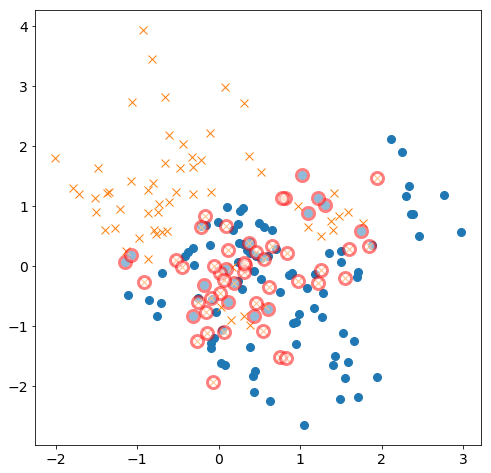

In [10]:
# Plot data
plt.plot(X[y == 0, 0], X[y == 0, 1], "o", markersize=8)
plt.plot(X[y == 1, 0], X[y == 1, 1], "x", markersize=8)

# Draw a red circle around misclassified samples
errors = (y != est_labels)
plt.plot(
    X[errors, 0], X[errors, 1], "o", color="red", alpha=0.5,
    markeredgewidth=3, markerfacecolor="white", markersize=12
)

As expected, mistakes happen in regions where the majority of points belong to the other class.

## Training vs. generalization

But what happens when we try to classify points outside the training set? There are a few different ways of assessing this. For instance, we could have used only part of our data in the training set (say around 80%), and use the remaining to compute the so-called test error.
Since in our case however the generative model is known, we might as well just get more samples from it.

In [11]:
# Sample test data from the model
testsamples_per_class = 10000

class0_testlabels = np.random.randint(10, size = testsamples_per_class)
class1_testlabels = np.random.randint(10, size = testsamples_per_class)
class0_testsamples = class0_centroids[class0_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)
class1_testsamples = class1_centroids[class1_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)

X_test = np.vstack((class0_testsamples, class1_testsamples))
y_test = np.hstack((np.zeros(testsamples_per_class), np.ones(testsamples_per_class)))

# Compute distance matrix between X and X_test
distances_test = cdist(X, X_test)
print(distances_test)
print("distances_test.shape = ", distances_test.shape)

[[ 3.5732637   3.86358374  4.02502193 ...,  3.02240194  3.14250492
   2.96812116]
 [ 1.59908095  2.42250424  0.28347948 ...,  1.5898039   1.16155266
   1.40239938]
 [ 2.23216307  2.63704986  2.71004842 ...,  1.92969812  1.83590139
   1.62081943]
 ..., 
 [ 0.83775016  1.44086168  1.60981466 ...,  1.65056654  0.95955984
   0.58441536]
 [ 0.57996955  0.35448715  1.91163831 ...,  2.6760603   1.83385748
   1.55995445]
 [ 0.54944978  1.07712572  1.65090826 ...,  1.9460982   1.1756128
   0.81766397]]
distances_test.shape =  (200, 20000)


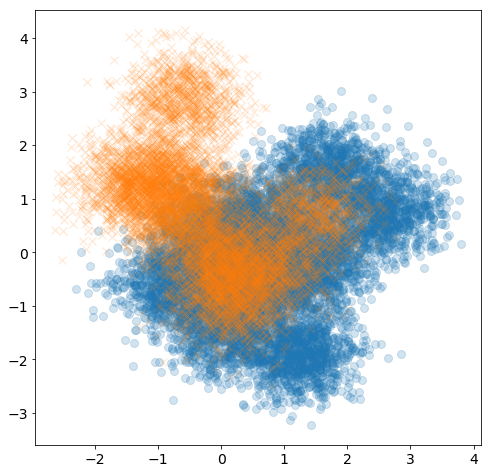

In [12]:
# Plot test data
plt.plot(X_test[y_test == 0, 0], X_test[y_test == 0, 1], "o", ms=8, alpha=0.2)
plt.plot(X_test[y_test == 1, 0], X_test[y_test == 1, 1], "x", ms=8, alpha=0.2)

We now write a function similar to `knn` that computes the estimates not for the points on the training set, but for points on a new *test* set.

In [13]:
def knn_test(X_train, y_train, X_test, y_test, k):
    n_train, n_test = len(y_train), len(y_test)
    distances = cdist(X_train, X_test)
    estimate = np.zeros(n_test)
    
    # For each sample in the test set...
    for i in range(n_test):
        # Look up k closest samples in the training set
        nns = np.argpartition(distances[:, i], k)[:k]
        
        # Assign estimate as a majority vote
        estimate[i] = int((sum(y_train[nns] == 1)) > sum(y_train[nns] == 0))

    return estimate

est_testlabels = knn_test(X, y, X_test, y_test, 10)
print(est_testlabels)

# Let us compute the test error, now
print("test error (misclassification):", np.mean(y_test != est_testlabels))

[ 0.  1.  0. ...,  0.  0.  0.]
test error (misclassification): 0.28055


One problem that we have when using $k$-nearest neighbors is that we have to pick a value for $k$ -- it is not clear in principle how to do it! 
In order to understand this better, let us look at how the training and test errors behave as a function of $k$.

k = 1; train error = 0, test error = 0.3249
k = 2; train error = 0.19, test error = 0.2975
k = 3; train error = 0.22, test error = 0.30495
k = 4; train error = 0.225, test error = 0.28915
k = 5; train error = 0.215, test error = 0.28805
k = 6; train error = 0.24, test error = 0.2852
k = 7; train error = 0.245, test error = 0.28225
k = 8; train error = 0.245, test error = 0.28015
k = 9; train error = 0.26, test error = 0.27825
k = 10; train error = 0.27, test error = 0.28055
k = 11; train error = 0.265, test error = 0.2785
k = 12; train error = 0.265, test error = 0.277
k = 13; train error = 0.255, test error = 0.27265
k = 14; train error = 0.27, test error = 0.27715
k = 15; train error = 0.26, test error = 0.2776
k = 16; train error = 0.255, test error = 0.28285
k = 17; train error = 0.24, test error = 0.2801
k = 18; train error = 0.265, test error = 0.2826
k = 19; train error = 0.255, test error = 0.27855


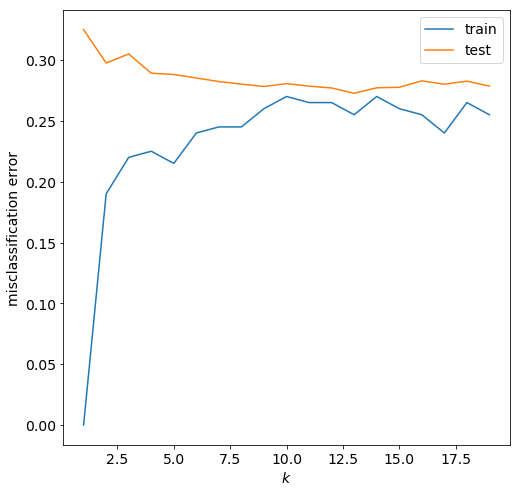

In [14]:
# Convenience functions that compute the training and test errors, given training and test samples
def compute_train_error(X, y, k=1):
    y_hat = knn(X, y, k)
    return np.mean(y != y_hat)
    
def compute_test_error(X_train, y_train, X_test, y_test, k=1):
    y_hat = knn_test(X_train, y_train, X_test, y_test, k)
    return np.mean(y_test != y_hat)

# Run functions for k belonging to a range of values
ks = np.arange(1, 20)
train_error = []
test_error = []
for (i, k) in enumerate(ks):
    train_error.append(compute_train_error(X, y, k))
    test_error.append(compute_test_error(X, y, X_test, y_test, k))
    print("k = %d; train error = %g, test error = %g" % (k, train_error[-1], test_error[-1]))

# Plot results
plt.plot(ks, train_error, label = "train")
plt.plot(ks, test_error, label = "test")
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel("misclassification error")

It is instructive to use another quantity in the x axis instead of $k$: the number of degrees of freedom $N / k$. Indeed, the larger the $k$, the smaller the number of effective parameters -- think for instance of the $k = N$ limit, where everyone is assigned the same label.

In [15]:
# Re-run the experiment above for a different range of values
ks = np.r_[np.arange(1, 10), np.arange(10, 150, 30)]
train_error = []
test_error = []
for k in ks:
    train_error.append(compute_train_error(X, y, k))
    test_error.append(compute_test_error(X, y, X_test, y_test, k))
    print("k = %d; train error = %g, test error = %g" % (k, train_error[-1], test_error[-1]))

k = 1; train error = 0, test error = 0.3249
k = 2; train error = 0.19, test error = 0.2975
k = 3; train error = 0.22, test error = 0.30495
k = 4; train error = 0.225, test error = 0.28915
k = 5; train error = 0.215, test error = 0.28805
k = 6; train error = 0.24, test error = 0.2852
k = 7; train error = 0.245, test error = 0.28225
k = 8; train error = 0.245, test error = 0.28015
k = 9; train error = 0.26, test error = 0.27825
k = 10; train error = 0.27, test error = 0.28055
k = 40; train error = 0.3, test error = 0.28765
k = 70; train error = 0.31, test error = 0.30355
k = 100; train error = 0.335, test error = 0.31095
k = 130; train error = 0.35, test error = 0.31875


(0.025, 0.4)

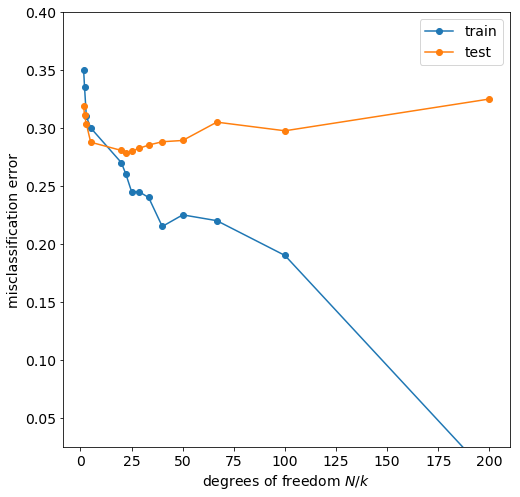

In [16]:
# Plot error as a function of the degrees of freedom
plt.plot(len(y) / np.array(ks), train_error, "-o", label = "train")
plt.plot(len(y) / np.array(ks), test_error, "-o", label = "test")
plt.legend()
plt.xlabel(r"degrees of freedom $N / k$")
plt.ylabel("misclassification error")
plt.ylim((0.025, 0.4))

This plot makes explicit the so-called *bias-variance tradeoff* that appears all throughout statistics. If we have more parameters, we are able to get smaller training error, but the test (analogously, generalization) error actually increases, meaning we are overfitting!

## A Python library for Machine Learning: scikit-learn

You might have noticed that running our implementation of $k$-NNs for 20000 samples already started to feel a bit sluggish... That is because it isn't really optimized. If we wanted things to be fast, we would have to recur to some C code, using Python extensions such as Cython or ctypes (that's actually what packages such as Numpy and Scipy do for us).
Moreover, we did things very naively -- for instance, one actually does not need to compute the full distance matrix if using appropriate data structures such as kd-trees etc.

Luckily for us there are people who already wrote optimized versions of most standard machine learning algorithms!

![scikit-learn website](sklearn.png)

So let's see how scikit-learn's k-NN implementation works. One nice thing about scikit-learn is that they have lots of examples available online, so we can just look for something similar to what we are trying to do. For k-NN classification in particular there's this: http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

In [17]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(10)
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

And done! With just three lines of code we were able to repeat everything we've been doing so far. Let us see if we get the same training error as before.

In [18]:
train_error = np.mean(y != clf.predict(X))
test_error = np.mean(y_test != clf.predict(X_test))
print("train/test error (for k=10): %g/%g" % (train_error, test_error))
# clf.score gives the score of the classifier
# here it's the accurary = proportion of correctly classified samples
train_accuracy = clf.score(X, y)
test_accuracy = clf.score(X_test, y_test)
print("train/test accurary: %g/%g" % (train_accuracy, test_accuracy))

train/test error (for k=10): 0.27/0.28055
train/test accurary: 0.73/0.71945


Since things are optimized here, we can even do cooler things such as plotting the actual decision boundaries. In order to do that, let us generate a grid and compute the estimate for each point in that grid.

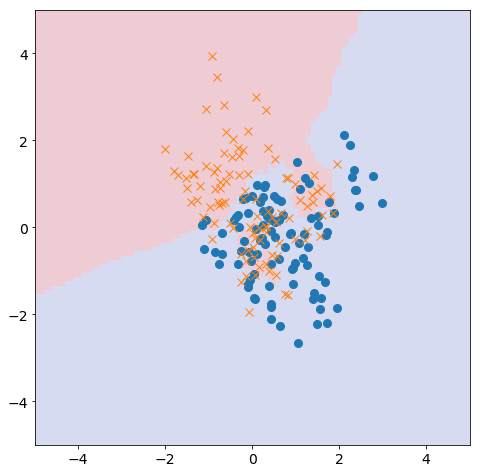

In [19]:
# Create a grid
xx, yy = np.meshgrid(np.linspace(-5, 5, 101), np.linspace(-5, 5, 101))
zz = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Do some plotting
zz = zz.reshape(xx.shape)
plt.imshow(zz, interpolation="nearest", cmap="coolwarm", alpha=0.2, origin="lower", extent=[xx.min(), xx.max(), yy.min(), yy.max()])
plt.plot(X[y == 0, 0], X[y == 0, 1], "o", markersize=8)
plt.plot(X[y == 1, 0], X[y == 1, 1], "x", markersize=8)

### Determining the best value of $k$ by cross-validation

One way of determining the "best" value of $k$ is by partitioning our dataset into two (training and validation sets) and then adjusting its value so as to minimize the validation error (we then need a 3rd set where we can compute the test error -- **never** adjust your parameters and compute the test error using the same set!)

However, this does not provide us good statistics since the partitioning is only done once; a perhaps better way of doing it is by partitioning the dataset again and again, and recomputing the score. This is the idea behind cross-validation.

scikit-learn has nice convenience functions to perform cross-validation for us. We gonna use `GridSearchCV`, which trains an estimator (in this case, the `KNeighborsClassifier`) across a range of parameters. For each of these parameters, the test error is computed using cross validation, more precisely 3-fold cross validation: the dataset is divided in 3, and all 3 combinations of 1 validation set + 2 training sets are tried, with the resulting validation error given by the average.

In [20]:
from sklearn.model_selection import GridSearchCV

# Set up the grid search
parameters = [{'n_neighbors': np.arange(1, 20)}]
clf = GridSearchCV(neighbors.KNeighborsClassifier(n_neighbors = 1), parameters)
clf.fit(X, y)

# Print results
print(clf.best_params_)
print(clf.cv_results_["mean_test_score"])

{'n_neighbors': 8}
[ 0.645  0.705  0.665  0.69   0.7    0.68   0.67   0.71   0.67   0.67   0.67
  0.68   0.665  0.665  0.68   0.685  0.68   0.685  0.665]


Let's see how this does on the test set.

In [21]:
train_error = np.mean(y != clf.predict(X))
test_error = np.mean(y_test != clf.predict(X_test))
print("train/test error (for optimal k): %g/%g" % (train_error, test_error))

train/test error (for optimal k): 0.245/0.28015


## Classification on real datasets: MNIST

Finally, let us work with a real dataset! If you have already studied a bit of machine learning and statistics, you are probably familiar with the MNIST dataset of handwritten digits. It is one of the most famous datasets used for benchmarking clustering and classification algorithms.

It is also included in scikit-learn. Let's see how to get it.

In [22]:
from sklearn.datasets import fetch_mldata

In [23]:
mnist = fetch_mldata('MNIST original', data_home=".")

Let's take a look at the data to see how it looks like.

X.shape =  (70000, 784)
y.shape =  (70000,)


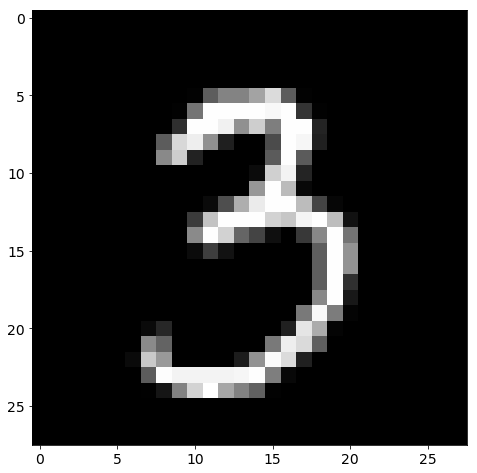

In [24]:
X = mnist.data
y = mnist.target
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)

n_samples, n_features = np.shape(X)

# Plot a sample
plt.imshow(X[20000, :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")

# Partition set into train/test
samples = np.random.randint(60000, size = 1000)
X_train, y_train = X[samples, :], y[samples]
X_test, y_test = X[60000:, :], y[60000:]

In [25]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

train_error = 1. - clf.score(X_train, y_train)
test_error = 1. - clf.score(X_test, y_test)
print("train/test error: %g/%g" % (train_error, test_error))

train/test error: 0.081/0.1369


This is good but not so much... It's quite slow, to start with. 

Let us look at the misclassified samples.

errors samples: [ 11  24  89  97 107 112 117 123 156 161 163 177 183 202 208 224 262 265
 276 280 297 305 316 351 355 363 370 371 383 417 432 450 458 478 489 505
 535 559 567 573 593 600 603 605 613 621 630 656 662 684 687 689 728 739
 750 766 790 793 812 825 834 838 839 847 853 867 877 885 890 902 905 911
 914 915 919 935 954 961 966 976 981]


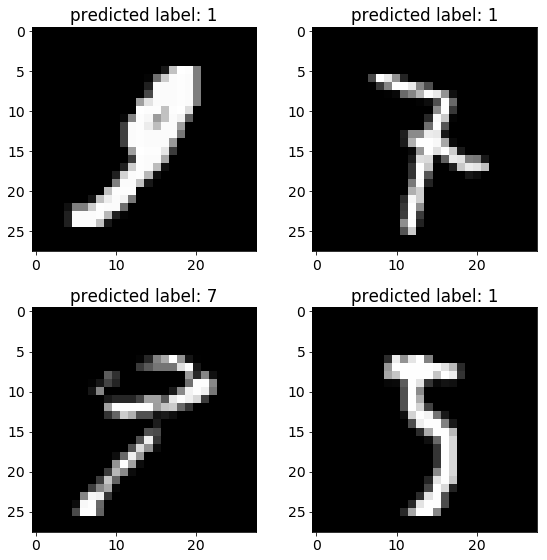

In [27]:
errors = np.where(y_train != clf.predict(X_train))[0]
print("errors samples:", errors)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(X_train[errors[0], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[0, 0].set_title("predicted label: %d" % (clf.predict(X_train[errors[0], :].reshape(1, -1))))
axs[0, 1].imshow(X_train[errors[1], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[0, 1].set_title("predicted label: %d" % (clf.predict(X_train[errors[1], :].reshape(1, -1))))
axs[1, 0].imshow(X_train[errors[2], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[1, 0].set_title("predicted label: %d" % (clf.predict(X_train[errors[2], :].reshape(1, -1))))
axs[1, 1].imshow(X_train[errors[3], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[1, 1].set_title("predicted label: %d" % (clf.predict(X_train[errors[3], :].reshape(1, -1))))
fig.tight_layout()

Before we ran $k$-NN on only two dimensions; now our vectors are much larger, they actually have 784 dimensions. It is expected that local methods such as $k$-NN don't work as well once we have gone to large dimensions, this is related to the curse of dimensionality.